# Imports and definitions

In [1]:
from utils import *
from paths_and_parameters import *
path_phases_check = path_figures + 'phases_check/'

paths_to_create_delete = [path_figures, path_phases_check, path_database_exp, path_calibrations]

#first_n_peaks = 5

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [2]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    for path_sel in paths_to_create_delete:
        if isdir(path_sel):
            rmtree(path_sel)

#### Check if output folders exist. If not, create them.

In [3]:
for path_sel in paths_to_create_delete:
    if not isdir(path_sel):
        makedirs(path_sel)

# Read and show photo of scanned section

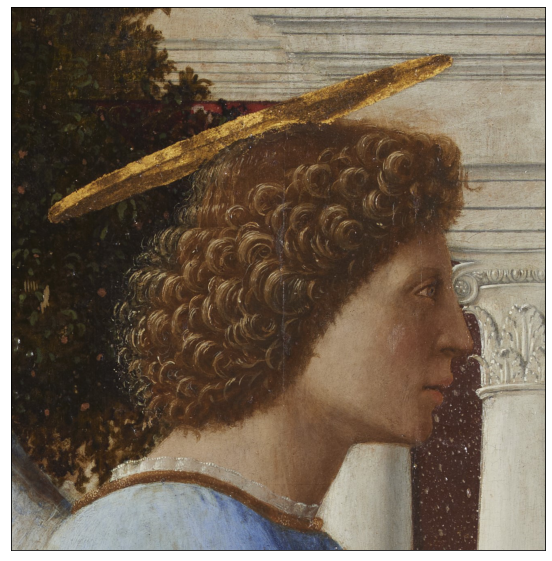

In [4]:
filenames = glob(path_photo + '*.jpg')
for filename in filenames:
    img_photo = Image.open(filename)
    fig, ax = subplots(figsize = (10, 10))
    ax.imshow(img_photo.transpose(1).rotate(90 * steps_rotation_photo, expand = True))
    ax.set_yticks([])
    ax.set_xticks([])
    show()

# Read phase database

In [5]:
print('Reading phases from: ' + ', '.join(["'" + path + "'" for path in list_path_database]))
database = DatabaseXRD()
for path_database in list_path_database:
    database.read_cifs(path_database)
print(f'Total number of phases: {len(database)}')

Reading phases from: '../../shared/Database/'
Total number of phases: 369


# Read XRD data
To recalculate h5 file, change just for one time the filename that the cell tries to read (indicated by the comment)

In [6]:
try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5') # to force the recalculation of h5 file, change this filename
    if any(not hasattr(data, attr) for attr in data.check_attributes):
        print('The present h5 file doesn\'t have all required information. Reading from raw data.')
        data = read_raw_XRD(path_xrd)
except:
    print('Reading from raw data.')
    data = read_raw_XRD(path_xrd)

data.rotate(steps_rotation_xrd)
y_x_ratio = data.shape[0] / data.shape[1]
print('\nShape of data\n-------------')
print(f'x: {data.shape[1]}, y: {data.shape[0]}, channels: {data.shape[2]}')
print('\nInitial calibration\n-------------------')
print(f'a = {data.opt[0]:.1f}, s = {data.opt[1]:.1f}, beta = {data.opt[2]:.3f}')
print(f'Theta range: {list(data.fce_calibration([0, data.shape[2]], *data.opt))}')

Loading: ../../shared/dataXRDXRF/Perugia/PieroDellaFrancesca/Cimasa/AngeloXRD/xrd.h5

Shape of data
-------------
x: 140, y: 188, channels: 1280

Initial calibration
-------------------
a = -1172.8, s = 2053.1, beta = 50.710
Theta range: [20.974350647292493, 53.699886668557056]


### Show burnt pixels
Choose a quantile on the value of maximum channel. All pixels above that quantile will be considered burnt pixel.

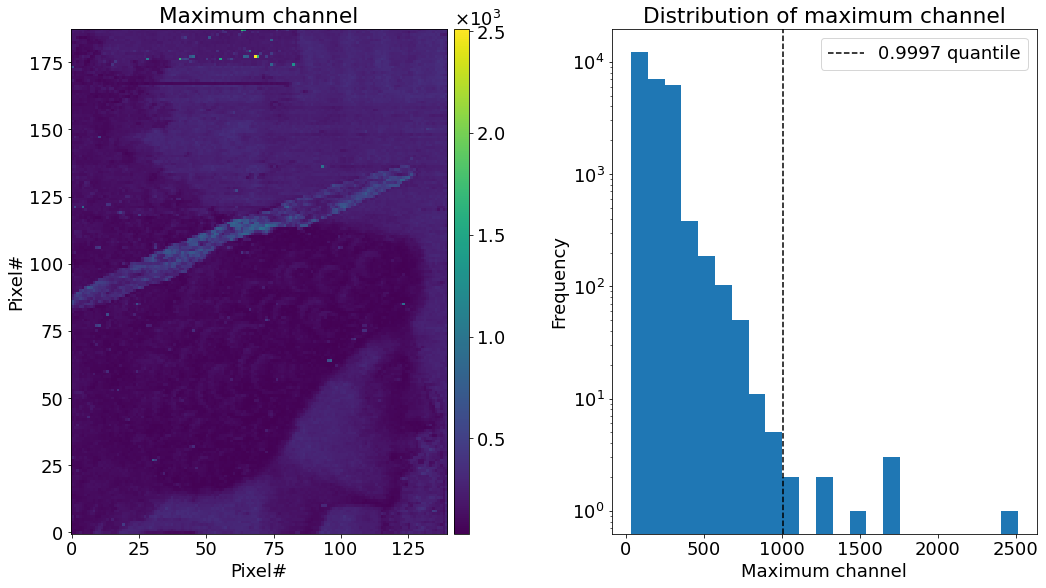

8 pixels out of 26320 are selected as burnt.


In [7]:
rcParams['font.size'] = 18

qtl = 0.9997

data_max = (data.data - data.background).max(axis = 2)
indices_to_correct = data_max > quantile(data_max, qtl)

fig, axs = subplots(1, 2, figsize = (15, 8))
fig.tight_layout(w_pad = 5)

ax = axs[0]
data_to_process = data.data - data.background
im = ax.imshow(data_max, interpolation = 'none')
formatter = ScalarFormatter(useMathText = True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 3))
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
cbar.ax.yaxis.set_offset_position('left')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')
ax.set_title('Maximum channel')

ax = axs[1]
ax.hist(data_max.flatten(), bins = 'doane') # 'sqrt'
ax.axvline(quantile(data_max, qtl), c = 'black', ls = '--', label = f'{qtl} quantile')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Maximum channel')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of maximum channel')

show()
print(f'{indices_to_correct.sum()} pixels out of {data.shape[0] * data.shape[1]} are selected as burnt.')

### Correct burnt pixels
Substitute burnt pixel with the average of the non burnt ones.

In [8]:
data.correct_quantile_pixels(qtl)

8 pixels out of 26320 were corrected.


### Show aggregated information: integral, average and maximum

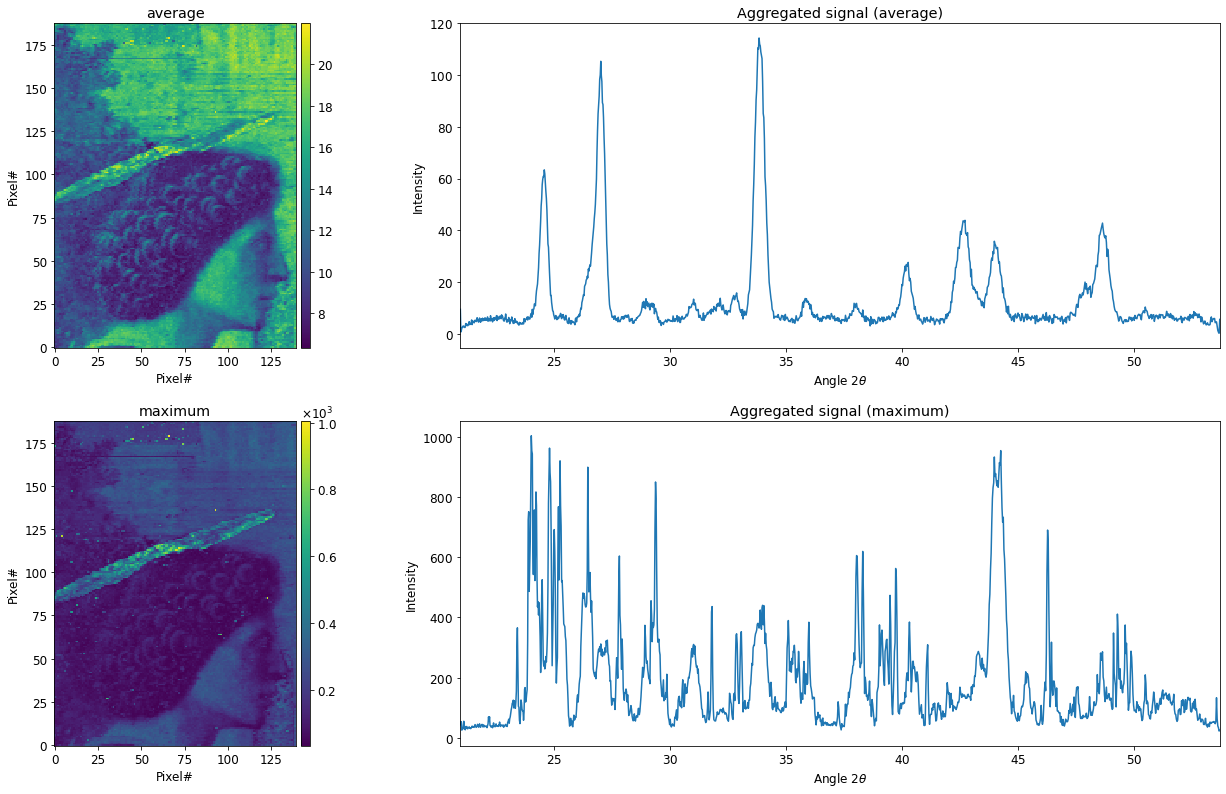

In [9]:
rcParams['font.size'] = 12

list_aggregations = ['integral', 'average', 'maximum']
list_functions = [sum, average, amax]
list_i = [1, 2]

fig, axs = subplots(len(list_i), 2, figsize = (18, len(list_i) * 4 * y_x_ratio), gridspec_kw = {'width_ratios': [1, 2]})
fig.tight_layout(h_pad = 4, w_pad = 5)

data_to_process = maximum(data.data - data.background, 0)
for j in range(len(list_i)):
    i = list_i[j]
    image_aggregated = list_functions[i](data_to_process, axis = 2)
    ax = axs[j, 0]
    im = ax.imshow(image_aggregated, interpolation = 'none')
    formatter = ScalarFormatter(useMathText = True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 3))
    cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02,0, 0.04, 1]), format = formatter)
    cb.ax.yaxis.set_offset_position('left')
    ax.set_title(list_aggregations[i])
    ax.set_ylabel(r'Pixel#')
    ax.set_xlabel(r'Pixel#')
    
    xrdpattern_aggregated = list_functions[i](data_to_process, axis = (0, 1))
    ax = axs[j, 1]
    ax.plot(data.x, xrdpattern_aggregated)
    ax.ticklabel_format(useMathText = True)
    ax.set_xlim(data.x[0], data.x[-1])
    ax.set_xlabel(r'Angle $2\theta$')
    ax.set_ylabel('Intensity')
    ax.set_title(f'Aggregated signal ({list_aggregations[i]})')

savefig(f'{path_figures}aggregated_info.png', bbox_inches = 'tight', dpi = 300)
show()

# Read XRF data

### Read XRF spectra

In [10]:
if path_xrf_spectra is not None:
    data_xrf_spectra = DataXRF().read(path_xrf_spectra).flip(axis = xrf_axes_flip).rotate(steps_rotation_xrf_spectra)
    y_x_ratio = data_xrf_spectra.data.shape[0] / data_xrf_spectra.data.shape[1]
    print('\nShape of data\n-------------')
    print(f'x: {data_xrf_spectra.shape[1]}, y: {data_xrf_spectra.shape[0]}, channels: {data_xrf_spectra.shape[2]}')
    len_channels_xrf = data_xrf_spectra.shape[2]

### Read element maps
If the orientation of tiff images does not correspond with XRD scans, flip them in this cell

In [11]:
data_xrf_elements = DataXRF().read_tiff(path_xrf_elements).flip(axis = xrf_axes_flip).rotate(steps_rotation_xrf_elements)
y_x_ratio = data_xrf_elements.labels.shape[0] / data_xrf_elements.labels.shape[1]
print(f'Found {data_xrf_elements.labels.shape[2]} images: ' + ', '.join([name for name in data_xrf_elements.metadata['labels']]))
print('\nShape of XRF element maps\n-------------------------')
print(f'x: {data_xrf_elements.labels.shape[1]}, y: {data_xrf_elements.labels.shape[0]}')

Found 22 images: Al_K, Au_L, Ba_L, Ca_K, Cl_K, Co_K, Cr_K, Cu_K, Fe_K, Hg_L, Hg_M, K_K, Mn_K, P_K, Pb_L, Pb_M, S_K, Sn_L, Sr_K, Ti_K, V_K, Zn_K

Shape of XRF element maps
-------------------------
x: 140, y: 188


### Correct burnt pixels and wrong scale in each element map; also calculate normalized element maps
Choose a quantile on the value of XRF intensity. All pixels above that quantile will be corrected as burnt pixels and will be assigned the threshold value.

In [12]:
qtl = 0.995

#data_xrf_elements.map_correct_specific_pixels([(0, 0)])
data_xrf_elements.map_correct_quantile_pixels(qtl).map_correct_scale()

maps_xrf_norm = data_xrf_elements.labels / data_xrf_elements.labels.max(axis = (0, 1), keepdims = True)

116 pixels out of 26320 were corrected on average in each XRF map.


# Obtain list of phases

### Search phases with given elements
- `elements_chosen`: Elements that need to be in the selected phases.
- `elements_excluded`: Elements that must not be in the selected phases.

In [13]:
elements_chosen = ['Sn']
elements_excluded = []
# DO NOT EXCLUDE: Al, Ca, Cl, P, S, Si

df_phases = DataFrame(columns = ['Name in database', 'Chemical formula', 'N. of samples'])
for phase_name, phase_set in sorted(database.items()):
    p = phase_set[0]
    if '_chemical_formula_sum' in p:
        if (all(is_element_in_formula(e, p['_chemical_formula_sum']) for e in elements_chosen)
            and all(not is_element_in_formula(e, p['_chemical_formula_sum']) for e in elements_excluded)):
            df_phases.loc[len(df_phases)] = [phase_name, p['_chemical_formula_sum'], len(phase_set)]
elements_excluded = []
df_phases

,Name in database,Chemical formula,N. of samples
0,Berndtite,S2 Sn,1
1,Berndtite-2T,S2 Sn,4
2,Cassiterite,O2 Sn,1
3,Co2SnO4,Co2 O4 Sn,1
4,Herzenbergite,S Sn,1
5,Lead-tin yellow,Pb2 Sn O4,1
6,Romarchite,O Sn,2
7,Tin (II) oxide - red modification,O Sn,2


### Select the area given by XRF threshold
- `threshold_XRF_intensity`: The routine selects pixels where the first of `elements_chosen` has an XRF intensity above this threshold value.

Element chosen for the map of XRF intensity: Sn_L
Threshold: 0.5
Selected pixels: 7877


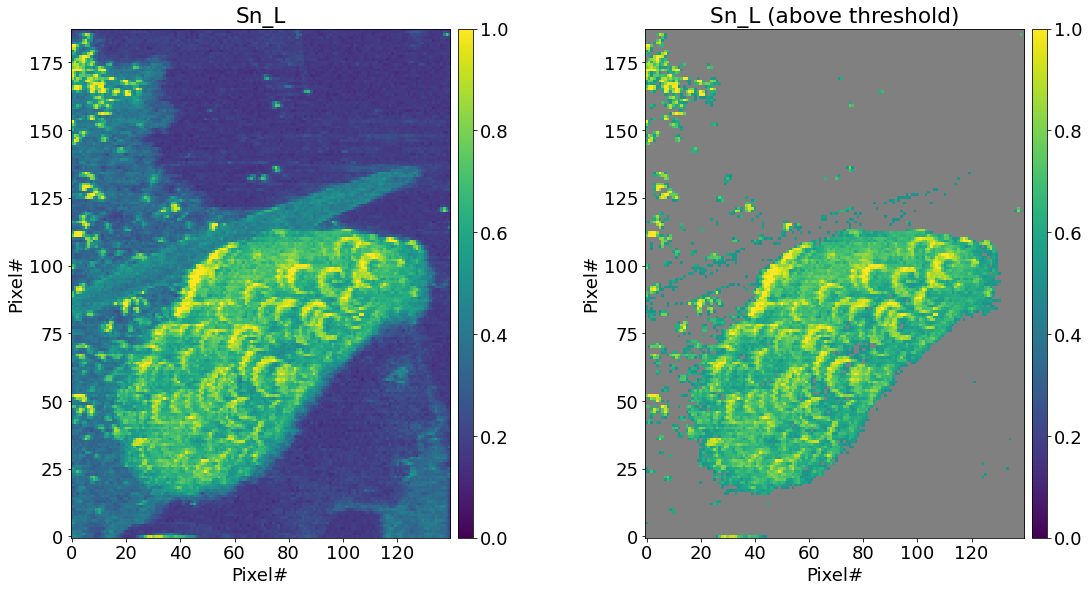

In [14]:
threshold_XRF_intensity = 0.5

rcParams['font.size'] = 18

###

idx_element = find_element(elements_chosen[0], data_xrf_elements.metadata['labels'])
print('Element chosen for the map of XRF intensity: ' + data_xrf_elements.metadata['labels'][idx_element])
print(f'Threshold: {threshold_XRF_intensity}')

indices_XRF_sel = zeros(data_xrf_elements.labels.shape[:2], bool)
for x in range(data_xrf_elements.labels.shape[1]):
    for y in range(data_xrf_elements.labels.shape[0]):
        if maps_xrf_norm[y, x, idx_element] >= threshold_XRF_intensity:
            indices_XRF_sel[y, x] = True
print(f'Selected pixels: {indices_XRF_sel.sum()}')

map_for_search = maps_xrf_norm[..., idx_element].copy()
map_for_search[~indices_XRF_sel] = nan

fig, axs = subplots(1, 2, figsize = (8 * 2, 6 * y_x_ratio))
fig.tight_layout(w_pad = 2)
cmap_viridis = get_cmap('viridis').copy()
cmap_viridis.set_bad(color = 'grey')

ax = axs[0]
im = ax.imshow(maps_xrf_norm[..., idx_element], interpolation = 'none', vmin = 0, vmax = 1)
colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
ax.set_ylabel(r'Pixel#')
ax.set_xlabel(r'Pixel#')
ax.set_title(data_xrf_elements.metadata['labels'][idx_element])

ax = axs[1]
im = ax.imshow(map_for_search, interpolation = 'none', vmin = 0, vmax = 1, cmap = cmap_viridis)
colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
ax.set_ylabel(r'Pixel#')
ax.set_xlabel(r'Pixel#')
ax.set_title(data_xrf_elements.metadata['labels'][idx_element] + ' (above threshold)')

show()

### In selected area, find the pixel of maximum XRF intensity of the first `elements_chosen`

In [15]:
quantile_xrf = 0.999   # Set to 1 to search for maximum, or to lowet values to search for the corresponding quantile.

threshold_qtl_xrf = nanquantile(map_for_search, quantile_xrf)
map_for_search_2 = map_for_search.copy()
map_for_search_2[map_for_search_2 > threshold_qtl_xrf] = nan
position = nanargmax(map_for_search_2)
y_xrf, x_xrf = unravel_index(position, map_for_search_2.shape)
print(f'Selected pixel: {(x_xrf, y_xrf)}')
print(f'Normalized XRF intensity: {map_for_search_2[y_xrf, x_xrf]:.3f}')

Selected pixel: (44, 44)
Normalized XRF intensity: 1.000


### Select peaks in phase

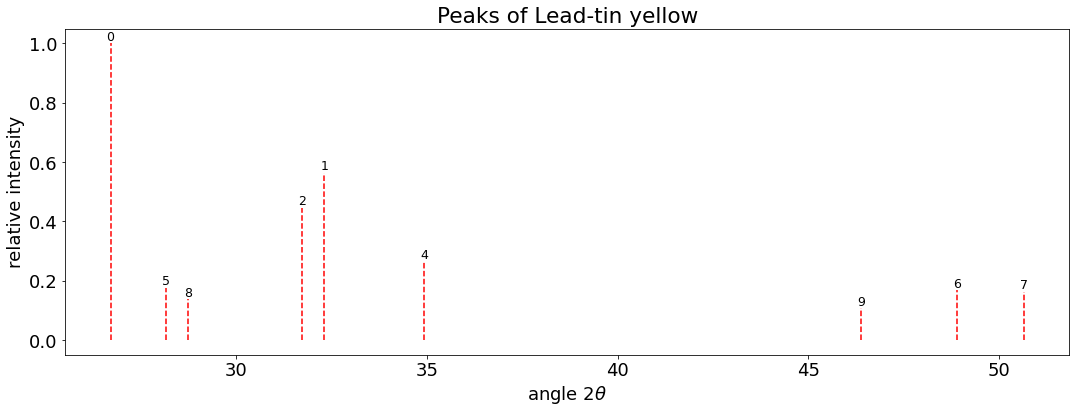

In [16]:
rcParams['font.size'] = 18

phase = database['Lead-tin yellow'][0]
peaks_selected = None #[i for i in range(15) if i != 3]

min_theta = 20
max_theta = 53
min_intensity = 0.1  # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None    # selects the first n most intense peaks (if None, leaves all the peaks)

phase.select_peaks(peaks_selected).get_theta(min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)

fig, ax = subplots(figsize = (18, 6))
sca(ax)
phase.plot(positions = True, min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'Peaks of {phase.label}')
show()

### Check phase vs smoothed XRD pattern in the given pixel

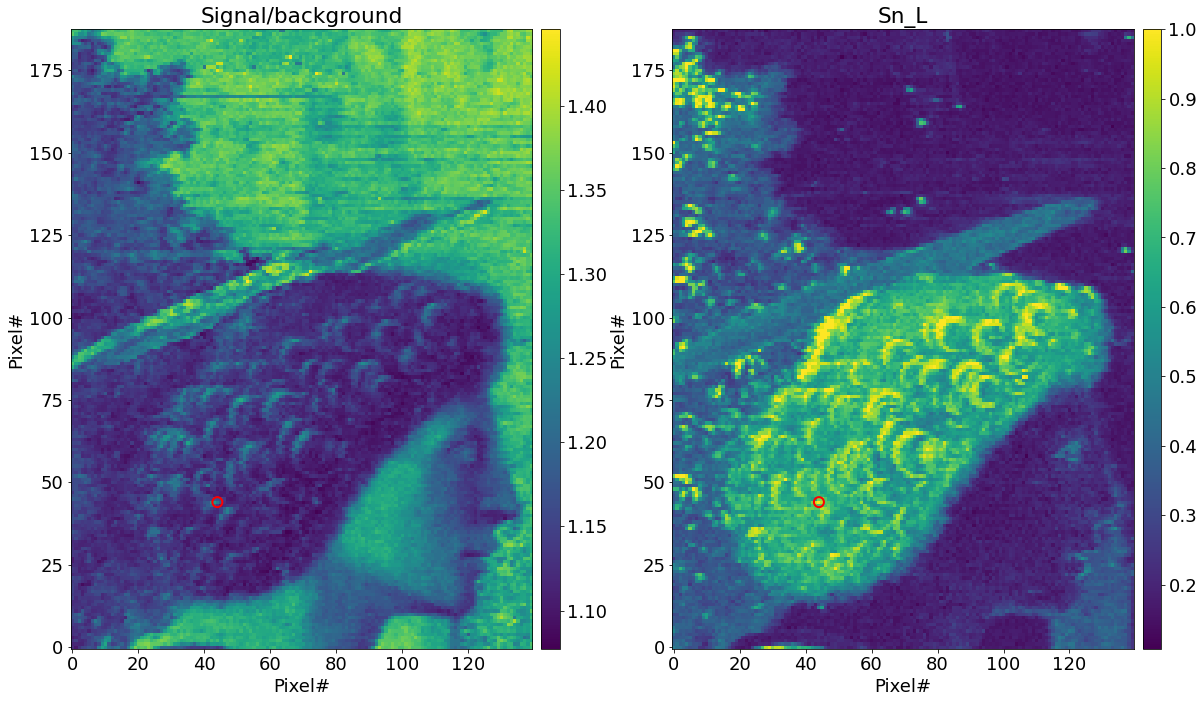

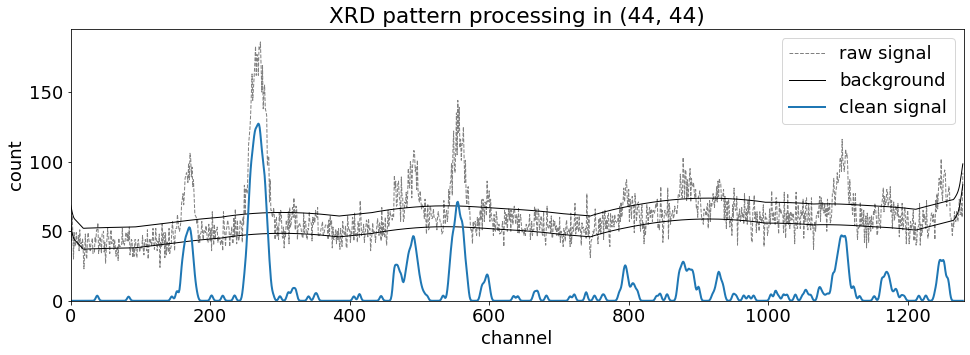

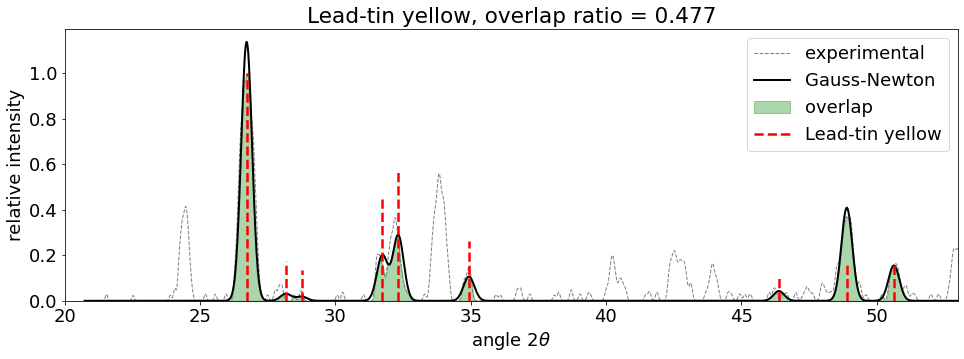

In [18]:
### Visualization options ###

rcParams['font.size'] = 18

#xrf_limits_channel = [0, len_channels_xrf]   # default limits
xrf_limits_channel = [0, 1000]              # custom limits

xrf_log_y = True


### Smoothing options ###
window_snip = 32        # width of the window used for determining the background (default 32)
offset_background = 15  # value added to the background, before subtracting it from the raw signal (default 0)
std_smooth = 2          # Float: strength of the final smooth applied to the XRD pattern (standard deviation of the Gaussian kernel used in the convolution)


### Fit options ###

# Phase that will be checked against the experimental XRD pattern
phase_check = database['Lead-tin yellow'][0]

# adjust_calibration: if False, initial calibration is kept; if True, calibration is adjusted by fitting phase_calibration on the experimental XRD pattern.
adjust_calibration = True
phase_calibration = database['Lead-tin yellow'][0]

# The diffraction lines of this phase will be shown for comparison. Set to None in order to have no comparison.
#phase_compare = database['Lazurite'][0]
phase_compare = None


###

### Calculations and plots ###

x, y = x_xrf, y_xrf

fig, axs = subplots(1, 2, figsize = (8 * 2, 8 * y_x_ratio))
fig.tight_layout(w_pad = 5)

ax = axs[0]
im = ax.imshow(data.signal_background_ratio.squeeze(), interpolation = 'none')
ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'red', facecolors = 'none')
colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
ax.set_ylabel(r'Pixel#')
ax.set_xlabel(r'Pixel#')
ax.set_title('Signal/background')

ax = axs[1]
im = ax.imshow(maps_xrf_norm[..., idx_element], interpolation = 'none')
ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'red', facecolors = 'none')
colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
ax.set_ylabel(r'Pixel#')
ax.set_xlabel(r'Pixel#')
ax.set_title(data_xrf_elements.metadata['labels'][idx_element])

show()

# XRF spectrum
if path_xrf_spectra is not None:
    fig, ax = subplots(figsize = (16, 5))
    ax.plot(data_xrf_spectra.data[y, x], lw = 2)
    if xrf_log_y:
        ax.set_yscale('log')
    ax.set_xlim(*xrf_limits_channel)
    ax.set_xlabel('channel')
    ax.set_ylabel('count')
    ax.set_title(f'XRF spectrum in {(x, y)}')
    show()


# XRD pattern
spectrum_xrd = (
    FastSpectraXRD()
    .from_Data(data, x, y)   
    .remove_background(window_snip = window_snip, offset_background = offset_background)
    .smooth_channels(std_kernel = std_smooth)
)

fig, ax = subplots(figsize = (16, 5))
ax.plot(spectrum_xrd.counts, c = 'grey', ls = '--', lw = 1, label = 'raw signal')
ax.plot(spectrum_xrd.background, c = 'black', ls = '-', lw = 1, label = 'background')
ax.plot(spectrum_xrd.background + spectrum_xrd.offset_background, c = 'black', ls = '-', lw = 1)
ax.plot(spectrum_xrd.counts_smoothed, lw = 2, label = 'clean signal')
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(0, len(spectrum_xrd.counts))
ax.set_ylim(0, None)
ax.set_xlabel('channel')
ax.set_ylabel('count')
ax.set_title(f'XRD pattern processing in {(x, y)}')
show()

gn = GaussNewton(phase_check, spectrum_xrd, min_theta = min_theta, max_theta = max_theta,
                 min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)

if adjust_calibration:
    gn_calibration = GaussNewton(phase_calibration, spectrum_xrd, min_theta = min_theta, max_theta = max_theta,
                                 min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)
    gn_calibration.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16)
    gn.opt = gn_calibration.opt.copy()

gn.fit_cycle(gamma = True, steps = 16)

# XRD fit
fig, ax = subplots(figsize = (16, 5))
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
ax.fill_between(gn.theta, gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
gn.phase.plot(lw = 2.5, alpha = 1, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)
if phase_compare is not None:
    phase_compare.plot(color = 'tab:blue')
ax.set_xlim(min_theta, max_theta)
ax.set_ylim(0, None)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('relative intensity')
ax.set_title(f'{gn.label}, overlap ratio = {gn.overlap_area_ratio():.3f}')
ax.legend(frameon = True, loc = 'upper right')
show()

### Smooth XRD data

In [19]:
### Smoothing options ###
window_snip = 32         # width of the window used for determining the background (default 32)
offset_background = 15   # value added to the background, before subtracting it from the raw signal (default 0)
std_smooth = 2           # degree of the final smooth applied to the XRD pattern (default 0)

data = data.remove_background(window_snip = window_snip, offset_background = offset_background).smooth_channels(std_smooth)

Removing background...
Done.
Smoothing along channels...
Done.


### Fit selected phases on smoothed XRD pattern in selected area

In [20]:
%%time

phase_presence_method = 'adjustment_ratio'
phase_presence_correction = False
# ('overlap_area', True), ('overlap_area_ratio', False), ('adjustment_ratio', False)

###

list_presence = []
list_presence_avg = []
list_presence_max = []
list_x_y = []

for i in range(df_phases.shape[0]):
    phase_name = df_phases['Name in database'].iloc[i]
    phase_set = database[phase_name]
    print(f'Calculations for {phase_name} ({len(phase_set)})... ', end = '')
    gm = GammaMap().from_data(data, [p for p in phase_set], indices_XRF_sel, sigma = sigma, min_theta = min_theta,
                                      max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)
    gm = gm.fit_cycle(gamma = True, steps = 10, verbose = False)
    presence = gm.format_as_1d_from_2d(gm.phase_presence(verbose = False, method = phase_presence_method, correction = phase_presence_correction))
    list_presence.append(presence)
    list_presence_avg.append(nanmean(presence, axis = 0))
    list_presence_max.append(nanmax(presence, axis = 0))
    list_x_y_sample = []
    for j in range(len(phase_set)):
        list_x_y_sample.append(gm.get_x_y(nanargmax(presence[:, j])))
    list_x_y.append(array(list_x_y_sample))
    
    print('Done.')

df_phases['Best avg presence'] = [nanmax(list_presence_avg[i]) for i in range(df_phases.shape[0])]
df_phases['Best max presence'] = [nanmax(list_presence_max[i]) for i in range(df_phases.shape[0])]
df_phases.style.format({'Best avg presence': '{:.3f}', 'Best max presence': '{:.3f}'})

Calculations for Berndtite (1)... Done.
Calculations for Berndtite-2T (4)... Done.
Calculations for Cassiterite (1)... Done.
Calculations for Co2SnO4 (1)... Done.
Calculations for Herzenbergite (1)... Done.
Calculations for Lead-tin yellow (1)... Done.
Calculations for Romarchite (2)... Done.
Calculations for Tin (II) oxide - red modification (2)... Done.
CPU times: user 44.7 s, sys: 12 s, total: 56.7 s
Wall time: 1min 8s


,Name in database,Chemical formula,N. of samples,Best avg presence,Best max presence
0,Berndtite,S2 Sn,1,0.064,0.130
1,Berndtite-2T,S2 Sn,4,0.067,0.162
2,Cassiterite,O2 Sn,1,0.158,0.274
3,Co2SnO4,Co2 O4 Sn,1,0.027,0.111
4,Herzenbergite,S Sn,1,0.086,0.171
5,Lead-tin yellow,Pb2 Sn O4,1,0.229,0.478
6,Romarchite,O Sn,2,0.036,0.100
7,Tin (II) oxide - red modification,O Sn,2,0.076,0.164


### Select phase samples as primary or secondary phases

##### How thresholds are used
- `thresholds_presence_avg`. If avg presence of a phase is above the second threshold, the phase can be selected as primary. Otherwise, if avg presence is above the first threshold, the phase can be selected as secondary.
- `factor_quantile` ($f$). Let $q_1$ and $q_3$ be the first and third quantiles of the population of presence values of a given phase sample in the selected pixels. If the maximum presence is above $q_3 + f (q_3 - q_1)$, the phase sample is discarded for having outlier presence values.

##### Note
If a phase is selected as primary, it is prevented from being selected as secondary, even with a different sample.

In [22]:
thresholds_presence_avg = [0.05, 0.2]
factor_quantile = 3 # the higher, the more permissive the filter is with respect to outliers


def outlier_threshold(population, factor = 1.5):
    q1 = quantile(population, 0.25)
    q3 = quantile(population, 0.75)
    return q3 + factor * (q3 - q1)


list_sel_category = []
list_sel_name = []
list_sel_formula = []
list_sel_sample = []
list_sel_presence_avg = []
list_sel_presence_max = []
list_sel_x_y_presence_max = []

for i in range(df_phases.shape[0]):
    arr_outlier_threshold = array([outlier_threshold(list_presence[i][:, j], factor_quantile) for j in range(df_phases.loc[i, 'N. of samples'])])
    idx = (list_presence_avg[i] >= thresholds_presence_avg[1]) & (list_presence_max[i] <= arr_outlier_threshold)
    if any(idx):
        arr_sample_filtered = arange(df_phases.loc[i, 'N. of samples'])[idx]
        arr_presence_avg_filtered = list_presence_avg[i][idx]
        arr_presence_max_filtered = list_presence_max[i][idx]
        arr_x_y_filtered = list_x_y[i][idx]
        j = nanargmax(arr_presence_avg_filtered)
        
        list_sel_category.append('Primary')
        list_sel_name.append(df_phases.loc[i, 'Name in database'])
        list_sel_formula.append(df_phases.loc[i, 'Chemical formula'])
        list_sel_sample.append(arr_sample_filtered[j])
        list_sel_presence_avg.append(arr_presence_avg_filtered[j])
        list_sel_presence_max.append(arr_presence_max_filtered[j])
        list_sel_x_y_presence_max.append(tuple(arr_x_y_filtered[j]))
    else:
        idx = (list_presence_avg[i] >= thresholds_presence_avg[0]) & (list_presence_max[i] <= arr_outlier_threshold)
        if any(idx):
            arr_sample_filtered = arange(df_phases.loc[i, 'N. of samples'])[idx]
            arr_presence_avg_filtered = list_presence_avg[i][idx]
            arr_presence_max_filtered = list_presence_max[i][idx]
            arr_x_y_filtered = list_x_y[i][idx]
            j = nanargmax(arr_presence_avg_filtered)

            list_sel_category.append('Secondary')
            list_sel_name.append(df_phases.loc[i, 'Name in database'])
            list_sel_formula.append(df_phases.loc[i, 'Chemical formula'])
            list_sel_sample.append(arr_sample_filtered[j])
            list_sel_presence_avg.append(arr_presence_avg_filtered[j])
            list_sel_presence_max.append(arr_presence_max_filtered[j])
            list_sel_x_y_presence_max.append(tuple(arr_x_y_filtered[j]))

df_phases_sel = DataFrame({
    'Category': list_sel_category,
    'Phase': list_sel_name,
    'Formula': list_sel_formula,
    'Sample': list_sel_sample,
    'Presence avg': list_sel_presence_avg,
    'Presence max': list_sel_presence_max,
    '(x, y) presence max': list_sel_x_y_presence_max
})
df_phases_sel = df_phases_sel.sort_values(by = ['Category', 'Phase']).reset_index(drop = True)
df_phases_sel.style.format({'Presence avg': '{:.3f}', 'Presence max': '{:.3f}'})

,Category,Phase,Formula,Sample,Presence avg,Presence max,"(x, y) presence max"
0,Primary,Lead-tin yellow,Pb2 Sn O4,0,0.229,0.478,"(2, 112)"
1,Secondary,Berndtite,S2 Sn,0,0.064,0.130,"(45, 98)"
2,Secondary,Berndtite-2T,S2 Sn,3,0.067,0.146,"(75, 60)"
3,Secondary,Cassiterite,O2 Sn,0,0.158,0.274,"(42, 54)"
4,Secondary,Herzenbergite,S Sn,0,0.086,0.171,"(27, 167)"


### Add selected phases to their appropriate files

This cell writes the list of names of selected phases into the files `phases_selection_primary.dat` and `phases_selection_secondary.dat`. If the files do not exist, the cell creates them.

In [21]:
for category in ['Primary', 'Secondary']:
    filename = f'{subfolder_output}phases_selection_{category.lower()}.dat'
    df_phases_sel.loc[df_phases_sel['Category'] == category, ['Phase', 'Formula', 'Sample', 'Presence avg', 'Presence max']]\
    .to_csv(filename, header = False, index = False, mode = 'a', float_format = '%.3f')

### Delete the files with list of selected phases
Delete the files `phases_selection_primary.dat` and `phases_selection_secondary.dat`.

In [22]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    for file_name in ['phases_selection_primary.dat', 'phases_selection_secondary.dat']:
        if exists(subfolder_output + file_name):
            remove(subfolder_output + file_name)

# Check list of phases

### Check the fit of every phase in the point of maximum presence
- save figures
- save experimental phases

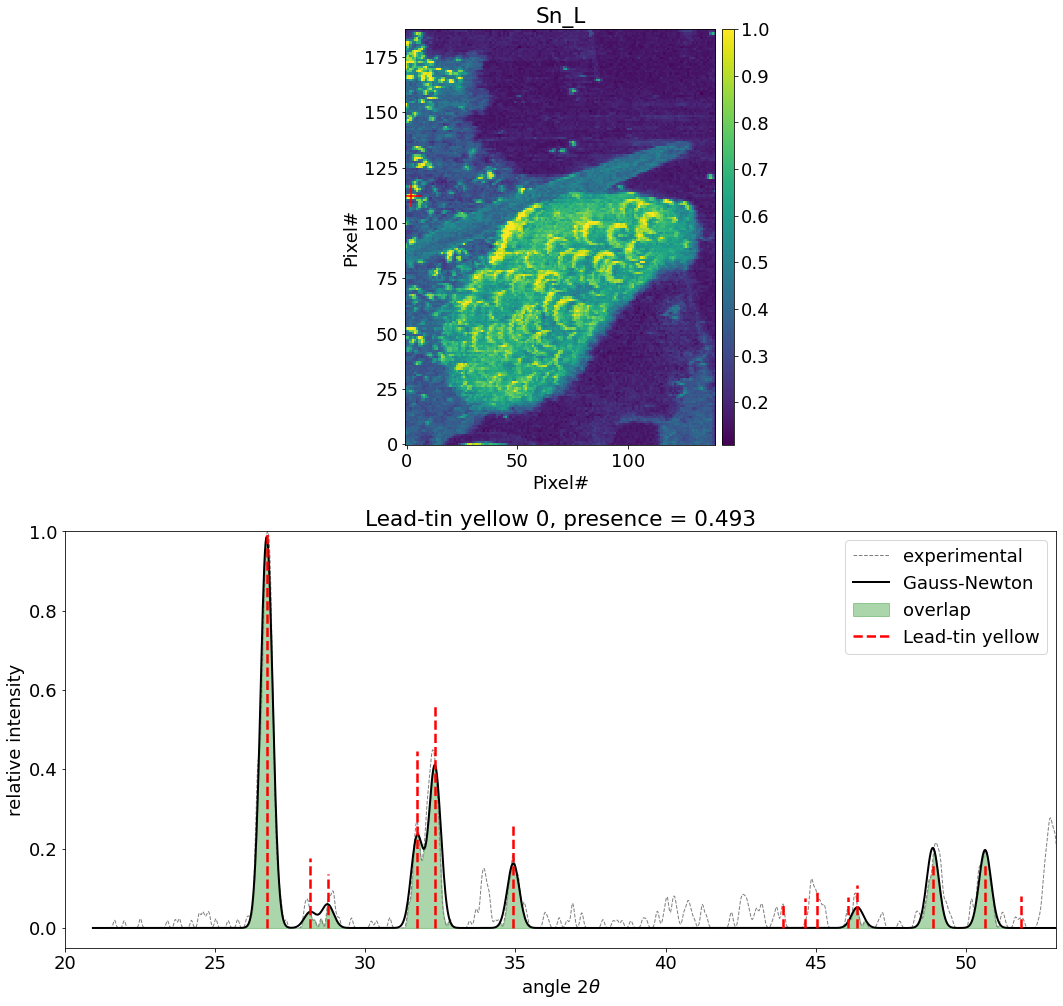

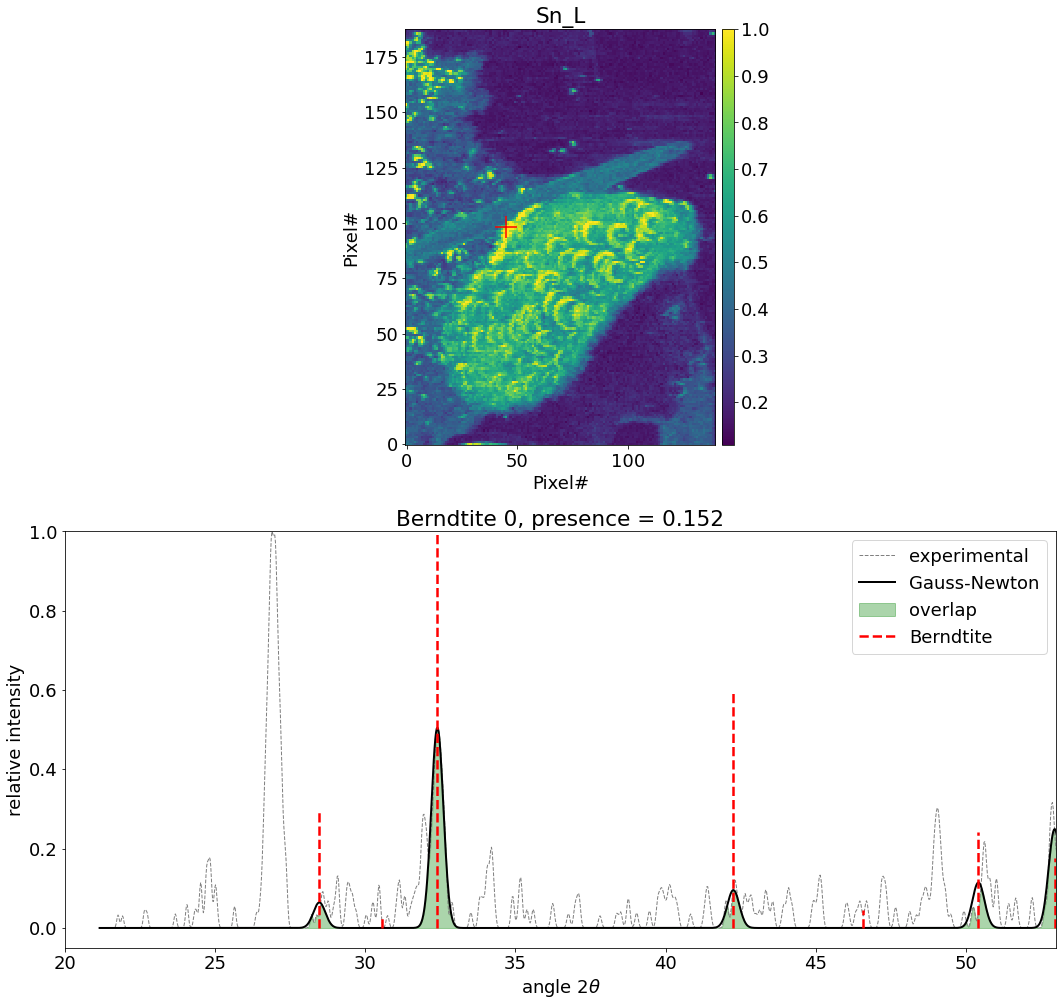

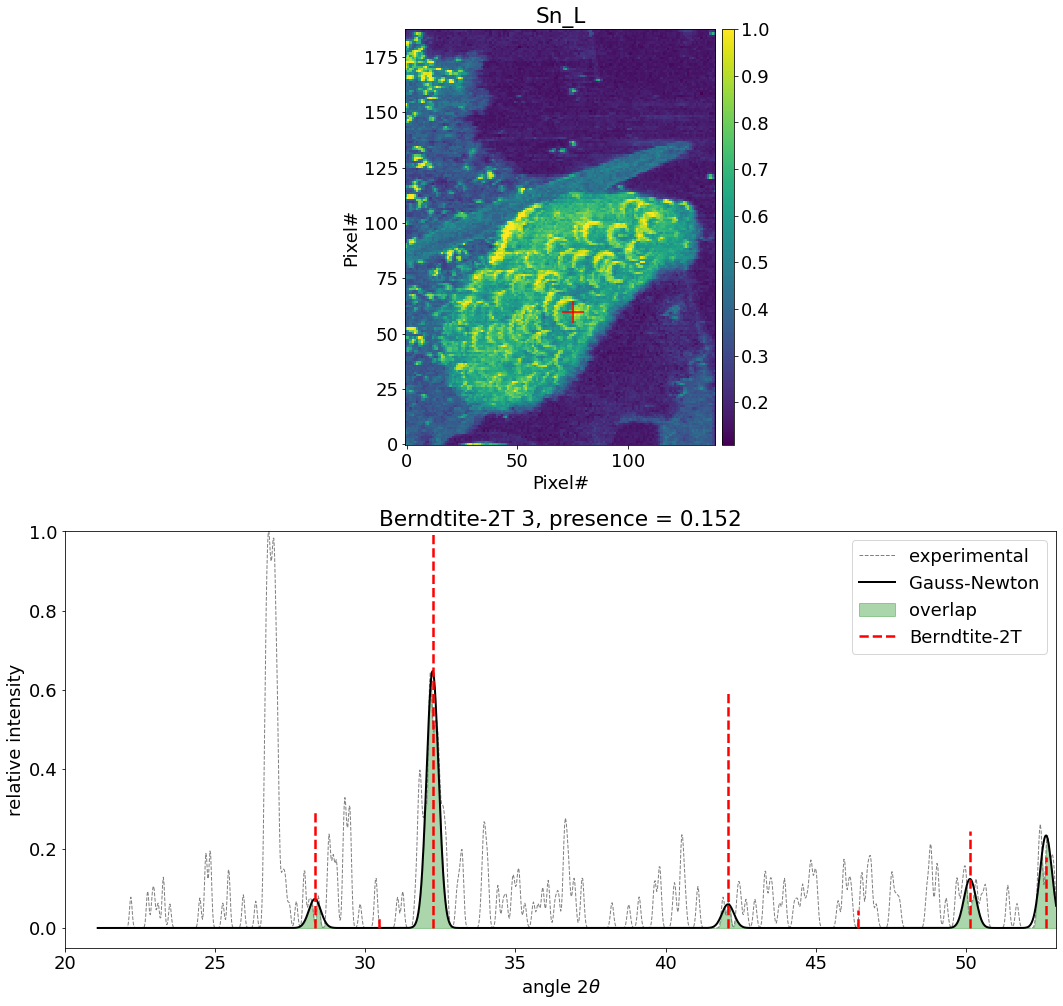

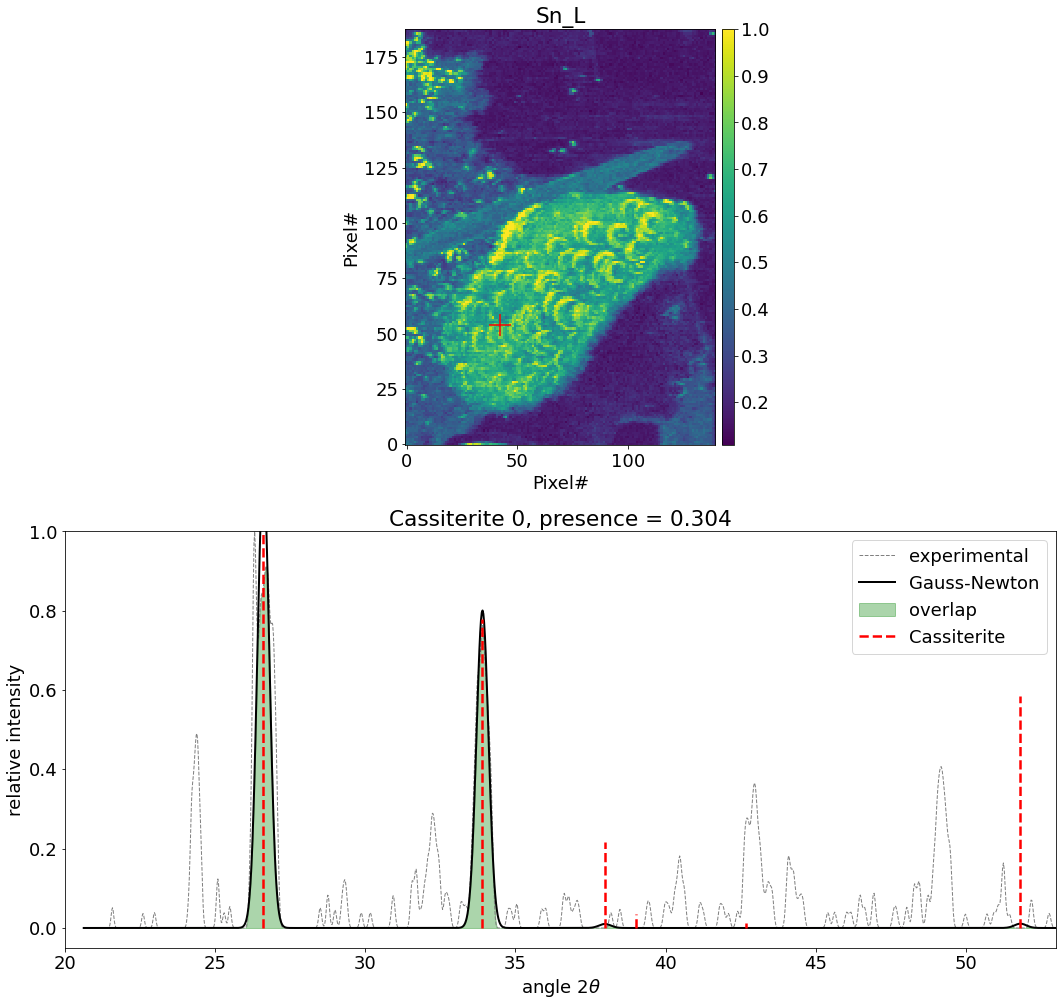

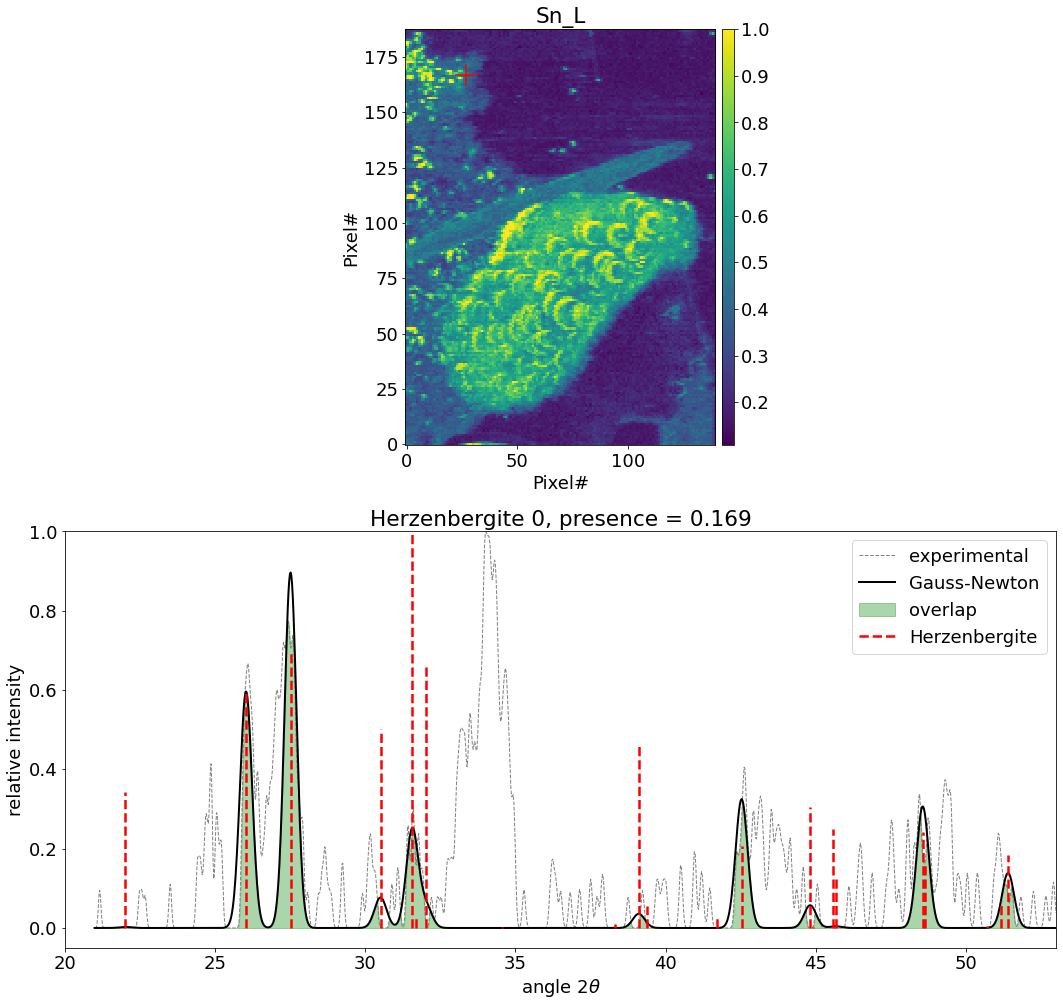

In [23]:
### Visualization options ###

rcParams['font.size'] = 18

#xrf_limits_channel = [0, len_channels_xrf]   # default limits
xrf_limits_channel = [0, 1000]              # custom limits

xrf_log_y = True


### Fit options ###

# adjust_calibration: if False, initial calibration is kept; if True, calibration is adjusted depending on the value of 'phase_calibration'.
# If phase_calibration is set to a specific phase, the calibration with that phase will be used for the exploration of all the phases.
# If phase_calibration is set to None, each phase is calibrated on experimental XRD pattern.
adjust_calibration = True
#phase_calibration = database['Jarosite'][15]
phase_calibration = None


### Calculations and plots ###

for i in range(df_phases_sel.shape[0]):
    phase_name = df_phases_sel.loc[i, 'Phase']
    phase_sample = df_phases_sel.loc[i, 'Sample']
    x, y = df_phases_sel.loc[i, '(x, y) presence max']
    phase_check = database[phase_name][phase_sample]

    gn = GaussNewton(phase_check, FastSpectraXRD().from_Data(data, x, y), min_theta = min_theta, max_theta = max_theta,
                     min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)
    
    if adjust_calibration:
        if phase_calibration is None:
            p = phase_check
        else:
            p = phase_calibration
        gn_calibration = GaussNewton(p, FastSpectraXRD().from_Data(data, x, y), min_theta = min_theta, max_theta = max_theta,
                                     min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)
        gn_calibration.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16)
        gn.opt = gn_calibration.opt.copy()
        
        arr_to_write = concatenate((gn.theta[:, newaxis], gn.spectrum.counts[:, newaxis]), axis = 1)
        savetxt(f'{path_calibrations}xrd_{x}_{y}_calibrated_with_{clean_phase_name(p.label)}.dat', arr_to_write, '%.3f %d')
    
    gn.fit_cycle(gamma = True, steps = 16)
    
    ### Save experimental phase ###
    phase_exp = gn.make_phase()
    filename = path_database_exp + clean_phase_name(gn.label) + '.cif'
    phase_exp.save_cif(filename)
    
    ### Plot ###

    if path_xrf_spectra is not None: # if we have XRF spectrum
        n_spectra = 2
    else:
        n_spectra = 1
    i = 0
    fig, axs = subplots(n_spectra + 1, 1, figsize = (15, 8 * y_x_ratio + 3 * n_spectra))
    fig.tight_layout(h_pad = 3)

    # Map of element
    ax = axs[i]
    i += 1
    im = ax.imshow(maps_xrf_norm[..., idx_element], interpolation = 'none')
    ax.scatter(x, y, s = 500, c = 'red', marker = '+')
    colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))
    ax.set_ylabel(r'Pixel#')
    ax.set_xlabel(r'Pixel#')
    ax.set_title(data_xrf_elements.metadata['labels'][idx_element])
    
    # XRF spectrum
    if path_xrf_spectra is not None:
        ax = axs[i]
        i += 1
        ax.plot(data_xrf_spectra.data[y, x], lw = 2)
        if xrf_log_y:
            ax.set_yscale('log')
        ax.set_xlim(*xrf_limits_channel)
        ax.set_xlabel('channel')
        ax.set_ylabel('count')
        ax.set_title(f'XRF spectrum in {(x, y)}')

    # XRD fit
    ax = axs[i]
    i += 1
    sca(ax)
    gn.plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
    gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
    ax.fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
    gn.phase.plot(lw = 2.5, alpha = 1)
    ax.set_xlim(min_theta, max_theta)
    ax.set_ylim(-0.05, 1)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(f'{phase_name} {phase_sample}, presence = {gn.phase_presence(method = phase_presence_method, correction = phase_presence_correction):.3f}')
    ax.legend(frameon = True, loc = 'upper right')

    savefig(f'{path_phases_check}{clean_phase_name(phase_name)} {x}_{y} check_fit.png', bbox_inches = 'tight', dpi = 300)
    show()
    close(fig)